# Krigging

In [2]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

 ### test init### 


### Preprocessing

In [3]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore') #.dt.tz_localize('Asia/Singapore')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202401\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202404\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)
WS_WindSpeed_df = LoadWeatherStationDataIntoDf('WindSpeed Ave (m/s)', dirs)
# WS_WDir_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)

start_date = '2024-01-01'
end_date = '2024-04-25'
# end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]
WS_relH_df_filtered_df = WS_relH_df.loc[start_date:end_date]
WS_Rad_df_filtered_df = WS_Rad_df.loc[start_date:end_date]
WS_Windspeed_df_filtered_df = WS_WindSpeed_df.loc[start_date:end_date]
#display(WS_Temp_filtered_df.columns)



C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\2121777147.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\2121777147.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\2121777147.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\2121777147.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


In [4]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)

general           = ['X', 'Y', 'Lat', 'Lon', 'Shortname']
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])


def add_closest_grid_info_multiple(WS_df, griddf, columns=[veg_percentage + veg_distances + bld_features + distance_features], num_closest=5):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values


features = general + distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
selection = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)
display(modified_WS_df)


kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\192617378.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotc

[1176, 1177, 1345, 1346, 1347, 2310, 2499, 2500, 2501, 2692, 3056, 3253, 3254, 3255, 3454, 3887, 3888, 4080, 4081, 4082, 4094, 4095, 4096, 4289, 4290, 5135, 5136, 5354, 5355, 5576, 6215, 6216, 6217, 6440, 6441, 7039, 7278, 7279, 7541, 7542, 8346, 8347, 8634, 8635, 8930, 12028, 12029, 12030, 12371, 12372, 14237, 14583, 14584, 14930, 14931, 16311, 16616, 16617, 16660, 16661, 16967, 16968, 17011, 17012, 17320, 19310, 19311, 19312, 19526, 19527, 19528, 19662, 19663, 19877, 19878, 19949, 19950, 19951, 20013, 20303, 20304, 20365, 20366, 20367, 20721, 20800, 20801, 21064, 21065, 21066, 21157, 21158, 21159, 21424, 21425, 25532, 25533, 25886, 25887, 26231, 29185, 29186, 29515, 29516, 29837, 30770, 30771, 30907, 31069, 31070, 31071, 31201, 31202, 31488, 31489, 31861, 31862, 32134, 32135, 32404, 39378, 39379, 39610, 39611, 39843, 46839, 46840, 46841, 47064, 47065, 49087, 49158, 49310, 49311, 49312, 49382, 49383, 49534, 49605, 49606, 54351, 54352, 54486, 54566, 54567, 54702, 54703, 54782, 54919, 5

C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\192617378.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)
C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\192617378.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)


Number/file name in AWS  Reflected in Google Map to NUS President  \
0                        76                                         1   
1                        60                                         2   
2                        62                                         3   
3                         3                                         4   
4                        75                                         5   
5                        73                                         6   
6                        61                                         7   
7                        29                                         8   
8                        25                                         9   
9                        11                                        10   
10                        6                                        11   
11                       72                                        12   
12                       48                                        13   
13                       42                                        14   
14                       33                                        15   
15                       67                                        16   
16                       32                                        17   
17                       31                                        18   
18                        9                                        19   
19                       47                                        20   
20                       36                                        21   
21                       13                                        22   
22                       65                                        23   
23                       14                                        24   
24                       18                                        25   
25                       39                                        26   
26                       24                                        27   
27                       50                                        28   
28                       37                                        29   
29                       68                                        30   
30                       17                                        31   
31                       69                                        32   
32                       16                                        33   
33                       56                                        34   
34                       77                                        35   
35                       43                                        36   
36                       74                                        37   
37                       45                                        38   
38                       57                                        39   
39                       44                                        40   

               Type                                           Longname  \
0   Weather station                      Lamp post - CP2A in front E3A   
1   Weather station                              Roof - E1A upper roof   
2   Weather station                      Lamp post - in between E2-E1A   
3   Weather station                               Railing - E1 level 2   
4   Weather station                              Railing - next to EW1   
5   Weather station                                       Roof - SDE3    
6   Weather station                        Column - shelter next to E8   
7   Weather station        Lamp post - U-Turn in front of LKCNH Museum   
8   Weather station                         Lamp post - roundabout YIH   
9   Weather station                        Lamp post - bus stop NUS IT   
10  Weather station            Column - AS8 / bus stop Central Library   
11  Weather station                                         Roof - AS3   
12  Weather station                   Lamp post 

### Linecharts

In [ ]:
### FILTER ALL DATA BY DAY! OR SHOW DAY AND NIGHT PLOT BELOW EACH OTHER?

### OR JUST ADD MEAN VALUES FOR DAY, STUDY PERIOD AND NIGHT?

In [ ]:
def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    start_date = '2024-01-01'
    end_date = '2024-03-15'
    WS_Temp_df = WS_Temp_df.loc[start_date:end_date]

    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Shading the area between min and max
    plt.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period')

    # Plotting the mean values as a thin red line
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: Min, Max, and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()



In [ ]:
plot_weather_station_data(WS_Temp_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)
plot_weather_station_data(WS_relH_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df, filepath_dir, "Linechart_SolRadiation.png", cYellow, 0, 1500)

In [ ]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df

# Calculate total values
total_values = df.sum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2)

# Customize box plot aesthetics
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os

# Assume WS_Temp_filtered_df, WS_Rad_df, WS_relH_df, WS_WindSpeed_df are already defined and contain the filtered data

# Function to rename columns by splitting with '_' separator and taking the first part
def rename_columns(df):
    df.columns = [col.split('_')[0] for col in df.columns]
    return df

# Rename columns for each DataFrame
WS_Temp_filtered_df = rename_columns(WS_Temp_filtered_df)
WS_Rad_df = rename_columns(WS_Rad_df)
WS_relH_df = rename_columns(WS_relH_df)
WS_WindSpeed_df = rename_columns(WS_WindSpeed_df)

# Function to compute cumulative counts DataFrame
def compute_cumulative_counts(df):
    availability_df = df.notna().astype(int)
    availability_df = availability_df.resample('D').sum().fillna(0)
    cumulative_counts_df = pd.DataFrame(index=availability_df.index)

    for station in availability_df.columns:
        cumulative_counts = availability_df[station].cumsum()
        cumulative_counts_df[station] = cumulative_counts

    return cumulative_counts_df.fillna(method='ffill').fillna(0)

# Compute cumulative counts for each DataFrame
cumulative_counts_temp_df = compute_cumulative_counts(WS_Temp_filtered_df)
cumulative_counts_rad_df = compute_cumulative_counts(WS_Rad_df)
cumulative_counts_relH_df = compute_cumulative_counts(WS_relH_df)
cumulative_counts_wind_df = compute_cumulative_counts(WS_WindSpeed_df)

# Function to cull stations based on a provided list
def cull_stations(df_list, stations_to_cull):
    if stations_to_cull:
        return [df.drop(columns=stations_to_cull, errors='ignore') for df in df_list]
    return df_list

# List of stations to cull (e.g., ['WS03', 'WS09'])
stations_to_cull = ['WS03', 'WS09']

# Cull stations in each DataFrame if the list is not empty
if (len(stations_to_cull) > 0)
    (cumulative_counts_temp_df,
    cumulative_counts_rad_df,
    cumulative_counts_relH_df,
    cumulative_counts_wind_df) = cull_stations([cumulative_counts_temp_df,
                                                cumulative_counts_rad_df,
                                                cumulative_counts_relH_df,
                                                cumulative_counts_wind_df], stations_to_cull)

# Define the study period ranges
study_period_1 = (pd.Timestamp('2024-01-18', tz='Asia/Singapore'), pd.Timestamp('2024-02-07', tz='Asia/Singapore'))
study_period_2 = (pd.Timestamp('2024-02-20', tz='Asia/Singapore'), pd.Timestamp('2024-03-15', tz='Asia/Singapore'))

# Number of weather stations to plot
num_stations = len(cumulative_counts_temp_df.columns)

# Check if there are any stations to plot
if num_stations > 0:
    # Define the number of columns per row
    cols_per_row = 5
    rows = int(np.ceil(num_stations / cols_per_row))

    # Create subplots
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 2 * rows), sharex=True, sharey=True)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Date format for the x-axis
    date_format = mdates.DateFormatter('%d.%m')

    # Plot each weather station's cumulative counts in its subplot using Seaborn
    for i, station in enumerate(cumulative_counts_temp_df.columns):
        ax = axes[i]

        # Plot Temperature data
        sns.lineplot(x=cumulative_counts_temp_df.index, y=cumulative_counts_temp_df[station], ax=ax, linestyle='-', alpha=0.5, label='Temperature', legend=False, color='red')
        
        # Plot Radiation data if exists
        if station in cumulative_counts_rad_df.columns:
            sns.lineplot(x=cumulative_counts_rad_df.index, y=cumulative_counts_rad_df[station], ax=ax, linestyle='--', alpha=0.5, label='Radiation', legend=False, color='yellow')
        
        # Plot Relative Humidity data if exists
        if station in cumulative_counts_relH_df.columns:
            sns.lineplot(x=cumulative_counts_relH_df.index, y=cumulative_counts_relH_df[station], ax=ax, linestyle='-.', alpha=0.5, label='Relative Humidity', legend=False, color='blue')

        # Plot Wind Speed data if exists
        if station in cumulative_counts_wind_df.columns:
            sns.lineplot(x=cumulative_counts_wind_df.index, y=cumulative_counts_wind_df[station], ax=ax, linestyle=':', alpha=0.5, label='Wind Speed', legend=False, color='green')
        
        ax.set_title(station)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Data Count')
        ax.grid(True)

        # Set the date format for x-axis
        ax.xaxis.set_major_formatter(date_format)

        # Add shaded regions to indicate study periods
        ax.axvspan(study_period_1[0], study_period_1[1], color='black', alpha=0.1, label='Study Period')
        ax.axvspan(study_period_2[0], study_period_2[1], color='black', alpha=0.1)

        # Hide the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide any unused subplots
    for j in range(num_stations, len(axes)):
        axes[j].axis('off')

    # Create a single legend at the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    filepath = os.path.join(filepath_dir, "CulledCumulativeDataCounts_Subplots_Seaborn.png")
    
    if filepath != "":
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()
else:
    print("No weather stations to plot.")


What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

## Regression Kriging


In [17]:
# OLD DEFINITIONS: Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)
wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat']) #pd.read_csv(parent_dir + 'WS_features.csv').fillna(0) #whz is this 43 and not 38


today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']

features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances

display(griddf.head(5))
display(wsdf.head(5))
wsdf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\WS_features_computed.csv')

print(features)

090824-1203


id      X      Y  BLD_percent  BLD_distance  VEG_Shrub_distance  \
0  345  20858  30677          0.0     46.321287           96.600803   
1  346  20858  30672          0.0     43.719667           96.785652   
2  347  20858  30667          0.0     41.559078           97.227619   
3  348  20858  30662          0.0     39.911210           97.923221   
4  349  20858  30657          0.0     38.841375           98.644098   

   VEG_Shrub_percent  STREET_CarPark_percent  STREET_CarPark_distance  \
0                0.0                     0.0               118.056128   
1                0.0                     0.0               121.144543   
2                0.0                     0.0               124.357354   
3                0.0                     0.0               127.685169   
4                0.0                     0.0               131.119234   

   STREET_CourtTrack_percent  ...  VEG_TypeC_distance  VEG_TypeD_percent  \
0                        0.0  ...           40.265030              0.000   
1                        0.0  ...           39.059487              0.000   
2                        0.0  ...           38.470955              0.000   
3                        0.0  ...           38.415606              0.257   
4                        0.0  ...           38.527721              0.072   

   VEG_TypeD_distance  VEG_TypeE_percent  VEG_TypeE_distance  BLD_Height  \
0            1.854786                0.0           55.533746         0.0   
1            0.171425                0.0           54.312697         0.0   
2            0.148362                0.0           53.530857         0.0   
3            0.000000                0.0           53.031281         0.0   
4            0.000000                0.0           52.956058         0.0   

   VEG_Tree_Height  BLDandVEG_SkyExp  BLDandVEG_Sun_h  Terrain_height  
0              0.0         73.807908                8        5.884193  
1              0.0         73.895025                8        5.961543  
2              0.0         75.224961                9        5.971716  
3              0.0         76.611243                8        5.861810  
4              0.0         82.890209                8        5.751740  

[5 rows x 34 columns]

X             Y Shortname  STREET_CarPark_percent  \
0  21090.276586  31446.608220      WS76                  0.3502   
1  21018.301427  31316.750821      WS60                  0.0000   
2  21066.835035  31298.582162      WS62                  0.0000   
3  21039.589703  31247.486168      WS03                  0.0000   
4  21036.026652  31177.437049      WS75                  0.0000   

   STREET_CarPark_distance  STREET_CourtTrack_percent  \
0                 0.137760                        0.0   
1                26.368922                        0.0   
2                64.375464                        0.0   
3                54.972402                        0.0   
4                54.784100                        0.0   

   STREET_CourtTrack_distance  STREET_Path_percent  STREET_Path_distance  \
0                  121.954487                  0.0             21.895744   
1                  233.184419                  0.0             40.373938   
2                  205.803563                  0.0             91.251008   
3                  261.295745                  0.0             89.120003   
4                  319.048430                  0.0             20.861799   

   STREET_Road_percent  ...  BLD_percent  BLD_Height  Terrain_height  \
0               0.3112  ...        0.000    0.000000       24.996696   
1               0.0000  ...        0.290   16.540116       34.407831   
2               0.0000  ...        1.000    0.000000       37.547951   
3               0.4718  ...        0.548   38.268177       37.041089   
4               0.1048  ...        0.642   18.182040       35.557390   

   VEG_TypeA_distance  VEG_TypeB_distance  VEG_TypeC_distance  \
0            0.000000            2.669324            6.903046   
1           11.887889            2.106516            7.291730   
2           63.634202           44.561607           39.762896   
3           47.455893           47.535387           42.237677   
4           33.157814           25.756954           27.684181   

   VEG_TypeD_distance  VEG_TypeE_distance  VEG_Turf_distance  \
0            0.335490            4.882615           0.000000   
1           10.896521           15.883104           0.913160   
2           29.811385           28.945288           0.000000   
3            4.683099            3.951791           2.416046   
4           20.637183           26.025345          24.544936   

   VEG_Shrub_distance  
0           44.523452  
1           13.761093  
2            1.238752  
3           49.869348  
4           56.712319  

[5 rows x 33 columns]

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']


### Get the Weather Data to interpolate


In [76]:
# Choose the data
# display(WS_Temp_filtered_df.describe())
# display(WS_Rad_df_filtered_df.describe())
# display(WS_relH_df_filtered_df.describe())

# --------------------------- FOR TEMPERATURE DATA
# measure = "AirTemperature"
# WS_Temp_df = WS_Temp_filtered_df

# WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
# WS_df = WS_Temp_df.transpose()
# --------------------------- FOR RADIATION DATA
measure = "Radiation"
WS_Rad_df = WS_Rad_df_filtered_df#LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)

WS_Rad_df.columns = [col.split('_')[0] for col in WS_Rad_df.columns]
WS_df = WS_Rad_df.transpose()

# --------------------------- FOR HUMIDITY DATA
# measure = "Humidity"
# WS_Rel_df = WS_relH_df_filtered_df

# WS_Rel_df.columns = [col.split('_')[0] for col in WS_Rel_df.columns]
# WS_df = WS_Rel_df.transpose()

# --------------------------- FOR WINDSPEED DATA
# measure = "WindSpeed"
# WS_WindSpeed_df = WS_Windspeed_df_filtered_df

# WS_WindSpeed_df.columns = [col.split('_')[0] for col in WS_WindSpeed_df.columns]
# WS_df = WS_WindSpeed_df.transpose()


#WS_Rad_df.to_csv('rad_test.csv')
display(WS_df)

Datetime  2024-01-01 00:00:00+08:00  2024-01-01 00:01:00+08:00  \
WS03                            NaN                        NaN   
WS06                            NaN                        NaN   
WS09                            NaN                        NaN   
WS11                            NaN                        NaN   
WS13                            NaN                        NaN   
WS14                            NaN                        NaN   
WS16                           22.0                       21.0   
WS17                            NaN                        NaN   
WS18                            NaN                        NaN   
WS24                            NaN                        NaN   
WS25                            NaN                        NaN   
WS29                            NaN                        NaN   
WS31                            NaN                        NaN   
WS32                            NaN                        NaN   
WS33                            NaN                       25.0   
WS36                            NaN                        NaN   
WS37                            NaN                        NaN   
WS39                            NaN                        NaN   
WS42                            NaN                        NaN   
WS43                            NaN                        NaN   
WS44                            NaN                        NaN   
WS45                            NaN                        NaN   
WS47                            NaN                        NaN   
WS48                            NaN                        NaN   
WS50                            NaN                        NaN   
WS56                            NaN                        NaN   
WS57                            NaN                        NaN   
WS60                            NaN                        NaN   
WS61                            NaN                        NaN   
WS62                            NaN                        NaN   
WS65                            NaN                        NaN   
WS67                            NaN                        NaN   
WS68                            NaN                        NaN   
WS69                            NaN                        NaN   
WS72                            NaN                        NaN   
WS73                            NaN                        NaN   
WS74                            NaN                        NaN   
WS75                            NaN                        NaN   
WS76                            NaN                        NaN   
WS77                            NaN                        NaN   

Datetime  2024-01-01 00:02:00+08:00  2024-01-01 00:03:00+08:00  \
WS03                            NaN                        NaN   
WS06                            NaN                        NaN   
WS09                            NaN                        NaN   
WS11                            NaN                        NaN   
WS13                            NaN                        NaN   
WS14                            NaN                        NaN   
WS16                           21.0                       20.0   
WS17                            NaN                        NaN   
WS18                            NaN                        NaN   
WS24                            NaN                        NaN   
WS25                            NaN                        NaN   
WS29                            NaN                        NaN   
WS31                            NaN                        NaN   
WS32                            NaN                        NaN   
WS33                           24.0                       23.0   
WS36                            NaN                        NaN   
WS37                            NaN                        NaN   
WS39                            NaN                        NaN   
WS42                            NaN    

In [ ]:
# GET COZIE DATA for MAIN
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['time_slice'], format='mixed') #  back to idnex time for main data
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]


In [77]:
# GET COZIE DATA for VALIDATION
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv', parse_dates=['time_slice'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['time_slice'], format='mixed') 
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_localize('Asia/Singapore')

def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

participant_data_local_df['c_longitude'] = participant_data_local_df.apply(combine_longitudes, axis=1)
participant_data_local_df['c_latitude'] = participant_data_local_df.apply(combine_latitudes, axis=1)

participant_data_local_df = participant_data_local_df[participant_data_local_df['c_longitude'].notnull()]
participant_data_local_df['c_run_number'] = 0


df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]


In [78]:
import pandas as pd
from pprint import pprint
from datetime import timedelta

# Load the CSV file
#importedTimesDf = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\times.csv')
# -----------------------
importedTimesDf = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\times_validation.csv', parse_dates=['timestamp'])
display(importedTimesDf)
importedTimesDf['timestamp'] = importedTimesDf['timestamp'].dt.tz_localize('Asia/Singapore')
# importedTimesDf = importedTimesDf.head(500) # --------------------------------------------------------------------------------------------- testing

length_before = len(importedTimesDf)
print(f"Length before reduction: {length_before}")

# Convert the 'timestamp' column to datetime if it’s not already in datetime format
importedTimesDf['timestamp'] = pd.to_datetime(importedTimesDf['timestamp'], format='mixed')

# Convert to 'Asia/Singapore' timezone if already timezone-aware
importedTimesDf['timestamp'] = importedTimesDf['timestamp'].dt.tz_convert('Asia/Singapore')

# Round timestamps to the nearest  minutes
importedTimesDf['rounded'] = importedTimesDf['timestamp'].dt.floor('1T')

# Remove duplicates based on the 'rounded' column
df_unique = importedTimesDf.drop_duplicates(subset=['rounded'])
length_after = len(df_unique)
print(f"Length after reduction: {length_after}")

# Get the resulting timestamps
index_time_list = df_unique['timestamp'].tolist()

# first_ten_items = index_time_list[:500] # --------------------------------------------------------------------------------------------- testing
# pprint(index_time_list)

# Format timestamps to include timezone offset
index_list_str = [
    dt.strftime('%Y-%m-%d %H:%M:%S') + dt.strftime('%z')[:3] + ':' + dt.strftime('%z')[3:]
    for dt in df_unique['timestamp']
]


reference_time_list = WS_df.columns

columns_to_keep = []

for index_time in index_time_list:
    closest_time = None
    min_diff = timedelta(minutes=3)

    for ref_time in reference_time_list:
        time_diff = abs(index_time - ref_time)
        if time_diff <= min_diff:
            closest_time = ref_time

    if closest_time is not None:
        columns_to_keep.append(closest_time)

# Remove duplicates and convert to list
columns_to_keep = list(set(columns_to_keep))

#print("Columns to keep:", columns_to_keep)
df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]


location_df = df[['index_time', 'c_longitude', 'c_latitude', 'c_run_number', 'id_participant']] #'c_run_number' #THIS IS WRONG WHERE DID GOT DF FROM?
location_df.set_index('index_time', inplace=True)
display(location_df)
location_df = location_df.drop(['c_run_number', 'id_participant'], axis=1)

selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]
#display(measure_df)

# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
df = df.drop('Shortname', axis=1)
df = df.reset_index(inplace=False)
df.columns = df.columns.astype(str)

#display(df.head(2))
pprint(df.columns)

pprint(index_list_str)



timestamp
0     2024-01-19 10:13:53
1     2024-01-19 10:19:41
2     2024-01-19 10:25:35
3     2024-01-19 10:27:13
4     2024-01-19 10:27:14
...                   ...
11590 2024-04-08 12:08:32
11591 2024-04-08 12:08:42
11592 2024-04-08 12:08:45
11593 2024-04-08 12:08:55
11594 2024-04-08 12:09:00

[11595 rows x 1 columns]

Length before reduction: 11595
Length after reduction: 1198


c_longitude  c_latitude  c_run_number  \
index_time                                                         
2024-01-19 10:13:53+08:00   103.770046    1.296455             0   
2024-01-19 10:19:41+08:00   103.770660    1.295367             0   
2024-01-19 10:25:35+08:00   103.771599    1.292992             0   
2024-01-19 10:27:13+08:00   103.773125    1.293045             0   
2024-01-19 10:27:14+08:00   103.772958    1.293073             0   
...                                ...         ...           ...   
2024-04-08 12:08:32+08:00   103.770980    1.297816             0   
2024-04-08 12:08:42+08:00   103.770860    1.297975             0   
2024-04-08 12:08:45+08:00   103.770929    1.297817             0   
2024-04-08 12:08:55+08:00   103.770878    1.297835             0   
2024-04-08 12:09:00+08:00   103.770828    1.297846             0   

                          id_participant  
index_time                                
2024-01-19 10:13:53+08:00         esse00  
2024-01-19 10:19:41+08:00         esse00  
2024-01-19 10:25:35+08:00         esse00  
2024-01-19 10:27:13+08:00         esse00  
2024-01-19 10:27:14+08:00         esse00  
...                                  ...  
2024-04-08 12:08:32+08:00         esse00  
2024-04-08 12:08:42+08:00         esse00  
2024-04-08 12:08:45+08:00         esse00  
2024-04-08 12:08:55+08:00         esse00  
2024-04-08 12:09:00+08:00         esse00  

[11595 rows x 4 columns]

Index(['index', 'Lat', 'Lon', '2024-04-07 14:38:00+08:00',
       '2024-03-11 14:44:00+08:00', '2024-02-21 16:40:00+08:00',
       '2024-02-21 16:21:00+08:00', '2024-04-07 13:58:00+08:00',
       '2024-02-21 16:36:00+08:00', '2024-04-07 10:43:00+08:00',
       ...
       '2024-02-21 16:45:00+08:00', '2024-04-06 16:50:00+08:00',
       '2024-04-06 16:31:00+08:00', '2024-03-21 16:50:00+08:00',
       '2024-04-06 16:12:00+08:00', '2024-04-06 16:46:00+08:00',
       '2024-04-06 16:27:00+08:00', '2024-04-08 12:08:00+08:00',
       '2024-03-11 14:48:00+08:00', '2024-03-11 14:29:00+08:00'],
      dtype='object', length=1201)
['2024-01-19 10:13:53+08:00',
 '2024-01-19 10:19:41+08:00',
 '2024-01-19 10:25:35+08:00',
 '2024-01-19 10:27:13+08:00',
 '2024-01-19 10:29:12+08:00',
 '2024-01-19 10:30:49+08:00',
 '2024-01-19 10:31:08+08:00',
 '2024-01-19 10:32:06+08:00',
 '2024-01-19 10:33:00+08:00',
 '2024-01-19 10:34:07+08:00',
 '2024-01-19 10:35:02+08:00',
 '2024-01-19 10:36:03+08:00',
 '2024-01-19 1

In [79]:
times = [col for col in df.columns if col not in ['index', 'Lat', 'Lon']]

index_list_str = [
    dt.strftime('%Y-%m-%d %H:%M:%S') + dt.strftime('%z')[:3] + ':' + dt.strftime('%z')[3:]
    for dt in location_df.index
]

# Convert list to string representation
# index_list_str = str(index_list_str)

print(len(times))
pprint(times)
pprint(index_list_str)
# times = index_list_str

1198
['2024-04-07 14:38:00+08:00',
 '2024-03-11 14:44:00+08:00',
 '2024-02-21 16:40:00+08:00',
 '2024-02-21 16:21:00+08:00',
 '2024-04-07 13:58:00+08:00',
 '2024-02-21 16:36:00+08:00',
 '2024-04-07 10:43:00+08:00',
 '2024-04-06 16:26:00+08:00',
 '2024-04-06 16:07:00+08:00',
 '2024-04-06 15:48:00+08:00',
 '2024-03-23 12:09:00+08:00',
 '2024-04-06 16:22:00+08:00',
 '2024-04-06 16:03:00+08:00',
 '2024-04-06 15:44:00+08:00',
 '2024-04-06 16:41:00+08:00',
 '2024-04-06 16:18:00+08:00',
 '2024-03-11 14:58:00+08:00',
 '2024-03-11 14:39:00+08:00',
 '2024-03-11 14:20:00+08:00',
 '2024-02-21 16:35:00+08:00',
 '2024-02-21 16:16:00+08:00',
 '2024-03-11 14:35:00+08:00',
 '2024-02-21 16:50:00+08:00',
 '2024-02-21 16:31:00+08:00',
 '2024-03-11 14:54:00+08:00',
 '2024-03-23 12:04:00+08:00',
 '2024-04-06 16:17:00+08:00',
 '2024-04-06 15:58:00+08:00',
 '2024-03-21 17:15:00+08:00',
 '2024-04-06 15:39:00+08:00',
 '2024-04-06 16:13:00+08:00',
 '2024-04-06 15:54:00+08:00',
 '2024-04-06 15:35:00+08:00',
 '202

### Clustering

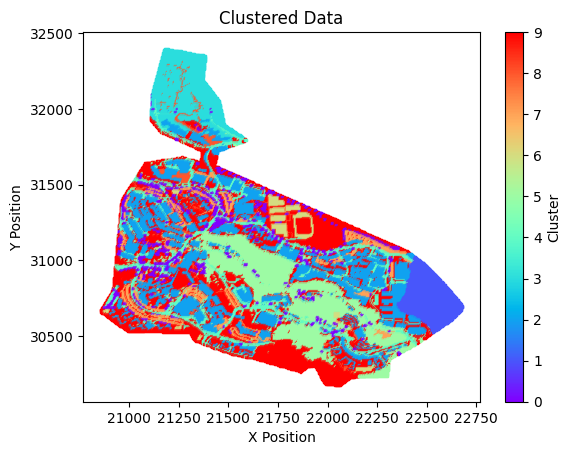

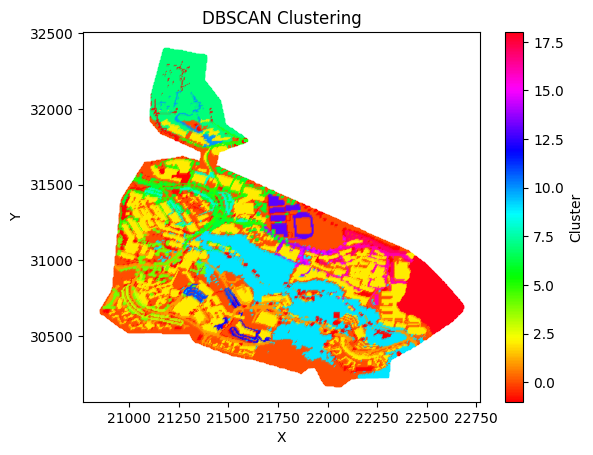

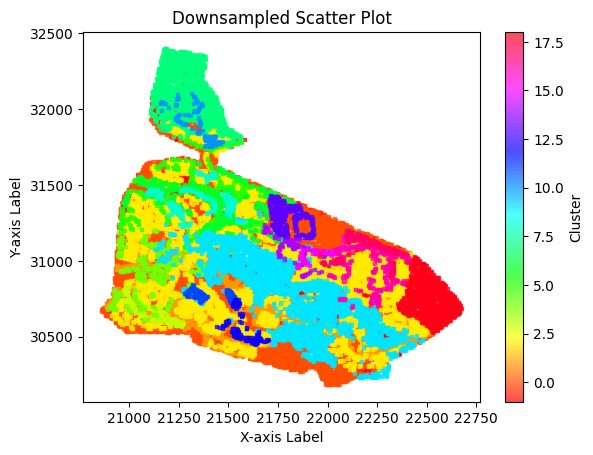

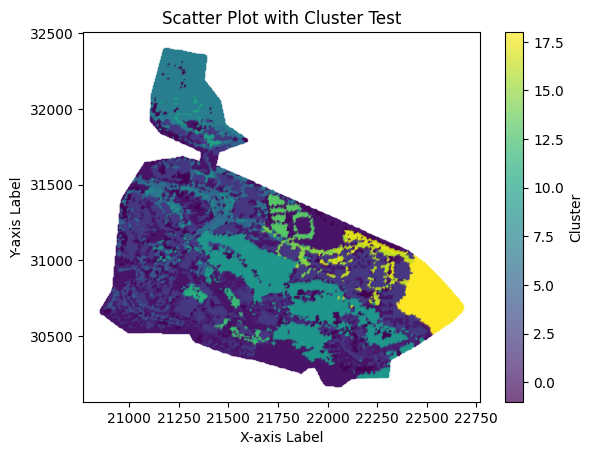

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance', 'cluster']


In [18]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = distance_features + veg_percentage  + bld_features + terrain_features + veg_distances


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()

#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.30
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Visualize Features

In [ ]:
def plot_heatmaps(dataframe, feature_list, cmap_list, n_cols=3, filepath_dir: str = 'test', filename: str = 'example.png'):
    """
    Plot heatmaps for the specified features in the given DataFrame using the provided colormaps.

    Parameters:
    - dataframe: pd.DataFrame containing the data
    - feature_list: List of column names to plot as features
    - cmap_list: List of colormaps to use for each feature
    - n_cols: Number of columns in the subplot grid (default is 3)
    """
    # Ensure no duplicate entries by averaging duplicates
    dataframe = dataframe.groupby(['X', 'Y'], as_index=False).mean()

    # Define number of rows for the subplot grid
    n_rows = (len(feature_list) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)

    for i, (feature, cmap) in enumerate(zip(feature_list, cmap_list)):
        ax = axes[i // n_cols, i % n_cols]
        
        # Reshape data into a grid
        x_unique = np.sort(dataframe['X'].unique())
        y_unique = np.sort(dataframe['Y'].unique())
        X, Y = np.meshgrid(x_unique, y_unique)
        Z = dataframe.pivot(index='Y', columns='X', values=feature).values

        # Plot heatmap
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Heatmap of {feature}')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(False)

    # Remove any unused subplots
    if len(feature_list) < n_rows * n_cols:
        for j in range(len(feature_list), n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    filepath = os.path.join(filepath_dir, filename)
    if filepath != "":
        directory = os.path.dirname(filepath)
            
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")


    plt.savefig(filepath)

    plt.show()

In [ ]:
feature_df = griddf
display(feature_df.head(5))
#features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
#feature_df.to_csv('test.csv')


terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


feature_list = veg_percentage
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3, filepath_dir, 'features_01')
feature_df.to_csv('test.csv')

feature_list = veg_distances
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_02')

feature_list = terrain_features + sky_features + bld_features
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_03')

feature_list = distance_features + ['cluster']
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_04')

# feature_list = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad']
# cmap_list = ['viridis', 'plasma', 'inferno', 'magma']
# plot_heatmaps(feature_df, feature_list, cmap_list)

### Regression Kriging

In [80]:
df_times = df.copy()
wsdf_cleaned = wsdf.copy()
df_times_cleaned = df_times.copy()

#### Filter the griddf

In [ ]:
#--------------------------------------------------------------------------
# MAIN
# FILTER AND SAVE THE GRIDDF for the main interpolation
#
#--------------------------------------------------------------------------

import pandas as pd
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree

# Define projection
wgs84 = Proj(init='epsg:4326')  # WGS84
utm = Proj(init='epsg:3414')    # Adjust to your UTM zone if needed

# Convert longitude and latitude to meters
def convert_location_data_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv')
participant_data_local_df = participant_data_local_df.dropna(subset=['c_longitude', 'c_latitude'])

# Convert participant data locations to meters
participant_data_local_df[['X', 'Y']] = participant_data_local_df.apply(
    lambda row: pd.Series(convert_location_data_to_meters(row['c_longitude'], row['c_latitude'])),
    axis=1
)

# Build a KDTree for participant_data_local_df
participant_tree = cKDTree(participant_data_local_df[['X', 'Y']])

# Define a function to check if there is a neighbor within a radius
def has_nearby_neighbors(x, y, radius=5):
    # Query the KDTree built from participant data
    distances, indices = participant_tree.query([x, y], k=len(participant_data_local_df), distance_upper_bound=radius)
    # Exclude the point itself and check if any other point is within the radius
    return any(dist < radius and dist > 0 for dist in distances)

# Create a 'keep' column for griddf
def check_keep(row):
    return has_nearby_neighbors(row['X'], row['Y'])

# Apply the neighbor check to griddf
griddf['keep'] = griddf.apply(check_keep, axis=1)

# Display the updated griddf
display(participant_data_local_df)
display(griddf)

griddf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep')

In [ ]:
#--------------------------------------------------------------------------
# SECONDARY
# FILTER AND SAVE THE GRIDDF for just the validation (esse00)
#
#--------------------------------------------------------------------------

import pandas as pd
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree

# Define projection
wgs84 = Proj(init='epsg:4326')  # WGS84
utm = Proj(init='epsg:3414')    # Adjust to your UTM zone if needed

# Convert longitude and latitude to meters
def convert_location_data_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

# Apply the function to create the new column


def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

man_participant_data_local_df = pd.read_csv(r"C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv")
man_participant_data_local_df['index_time'] = pd.to_datetime(man_participant_data_local_df['time_slice'],  format='%m/%d/%Y %H:%M:%S')

man_participant_data_local_df['c_latitude'] = man_participant_data_local_df.apply(combine_latitudes, axis=1)
man_participant_data_local_df['c_longitude'] = man_participant_data_local_df.apply(combine_longitudes, axis=1)
man_participant_data_local_df_filtered = man_participant_data_local_df.dropna(subset=['c_longitude', 'c_latitude'])

man_participant_data_local_df_filtered[['X', 'Y']] = man_participant_data_local_df_filtered.apply(
    lambda row: pd.Series(convert_location_data_to_meters(row['c_longitude'], row['c_latitude'])),
    axis=1
)

# Build a KDTree for participant_data_local_df
participant_tree = cKDTree(man_participant_data_local_df_filtered[['X', 'Y']])

# Define a function to check if there is a neighbor within a radius
def has_nearby_neighbors(x, y, radius=5):
    # Query the KDTree built from participant data
    distances, indices = participant_tree.query([x, y], k=len(man_participant_data_local_df_filtered), distance_upper_bound=radius)
    # Exclude the point itself and check if any other point is within the radius
    return any(dist < radius and dist > 0 for dist in distances)

# Create a 'keep' column for griddf
def check_keep(row):
    return has_nearby_neighbors(row['X'], row['Y'])

# Apply the neighbor check to griddf
griddf['keep'] = griddf.apply(check_keep, axis=1)

# Display the updated griddf
# display(man_participant_data_local_df_filtered)
display(griddf)

griddf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep_validation')

In [81]:
griddf = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep_validation')
#griddf = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep')
keep_counts = griddf['keep'].value_counts()
print("\nCount of True and False values in 'keep' column:")
print(keep_counts)

# Plotting with Plotly
fig = px.scatter(
    griddf,
    x='X',
    y='Y',
    color='keep',
    color_discrete_map={True: 'blue', False: 'red'},
    title='Grid Cells with Neighbors Within 5 Meters',
    labels={'X': 'X (meters)', 'Y': 'Y (meters)', 'keep': 'Has Neighbor Within 5 Meters'},
    height=800,
    width=800  # Adjust the height as needed
)

fig.update_traces(marker=dict(size=1))

# Show the plot
fig.show()

griddf = griddf.loc[griddf['keep'] == True]
grid = griddf



Count of True and False values in 'keep' column:
keep
False    61963
True     13207
Name: count, dtype: int64


## Interpolation

In [ ]:
# THIS IS OOOOLD!

import re

import warnings


# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

### Select features for model
measure = "Radiation"

def safe_float_conversion(x):
    try:
        return float(x)
    except ValueError:
        return x  
    
print(features)

dirOut = r'D:\Simulation\InterpolationResults'

grid = griddf
grid = grid.applymap(safe_float_conversion)


feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])
print("=" * 40)

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]



results_df = pd.DataFrame(columns=['time', 'X', 'Y', 'value'])


print('----------- STARTING: 0 out of ' + str(len(times)))
index = 1
debug: bool = False
for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for hours in times:

        date_part = hours.split()[0]
        year, month, day = date_part.split('-')
        
        # if (month == 1):
        # df_ws = wsdf_cleaned_Jan.copy()
        # df_times_inter = df_times_cleaned_Jan.copy()
        # else:
        df_ws = wsdf_cleaned.copy()
        df_times_inter = df_times_cleaned.copy()

        df_ws = df_ws.applymap(safe_float_conversion)
        df_times_inter = df_times_inter.applymap(safe_float_conversion)

        if hours in df_times_inter.columns:

            target = df_times_inter[hours].dropna()

            p = df_ws.loc[target.index, features]
            x = np.array(list(zip(df_ws.loc[target.index, 'X'], df_ws.loc[target.index, 'Y'])), dtype=float)

            target = np.array(target)

            if len(p) != len(target):
                print(f"Length mismatch after filtering: len(p) = {len(p)}, len(target) = {len(target)}.")
                print(f'Couldnt Process {hours}, invalid length for p and target')
                continue

            print(f"Processing: Column {hours} does exist in the dataframe.")

            filename = re.sub(r'[ :+]', '_', hours)
            filename = re.sub(r'-{2,}', '_', filename) 

            target_p = grid[features]
            target_x = np.array(list(zip(grid.X, grid.Y)))

            m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)
            print(f"Length of p: {len(p)}, Length of x: {len(x)}, Length of target: {len(target)}")
        else:
            print(f"Column {hours} does not exist in the dataframe.")
            print("=" * 40)
            continue

        

        if (len(p) != len(x) and len(p) != len(target)):
            #fix the p, x and target here, to the appropriate lenghts!    
            print(f'Couldnt Process {hours}, invalid lenght for p, x and target')
            continue

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = grid
        resultdf[measure] = result

        ### Append results to the results_df
        temp_df = resultdf[['id', 'X', 'Y']].copy()
        temp_df['time'] = hours
        temp_df['value'] = result
        results_df = pd.concat([results_df, temp_df])

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        minval = 22.5
        maxval = 40

        # Ensure output directory exists
        if not os.path.exists(dirOut + '/'+ today):
            os.makedirs(dirOut + '/'+ today)

        # ------------------------- PLOT START
        if (debug):
            plt.figure(figsize=(10, 7))

            # Scatter plot with custom color map and color range
            sc = plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
            plt.title('Scatter plot of ' + measure + ' (' + filename + ')')

            # Colorbar with custom ticks
            # cbar = plt.colorbar(sc)
            # ticks = [14.0, 16.5, 19.0, 21.5, 24.0, 26.5, 29.0, 31.5]
            # cbar.set_ticks(ticks)
            # cbar.set_ticklabels(ticks)

            # Axis limits
            ax = plt.gca()
            ax.set_xlim(20800, 22500)
            ax.set_ylim(30200, 31700)
            # Save CSV and optional PNG
            
            # plt.savefig(dirOut + today + '/' + measure + filename + '.png', bbox_inches='tight')

            plt.show()
        # ------------------------- PLOT END
        resultdf.to_csv(dirOut + '/' + today + '/' + measure + filename + '.csv')

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[hours] = m_rk.regression_model.feature_importances_
        print(f'{index} out of ' + str(len(times)))
        index = index + 1
        print("=" * 40)


In [82]:
# cull features
print(features)

features = ['VEG_Shrub_distance', 'BLDandVEG_SkyExp', 'VEG_TypeE_distance', 'BLD_percent', 'BLDandVEG_Sun_h', 'VEG_TypeD_distance', 'VEG_TypeC_distance', 'STREET_Walkway_distance', 'STREET_Road_distance', 'STREET_Path_distance', 'Terrain_height', 'cluster', 'VEG_TypeA_distance', 'STREET_CourtTrack_distance', 'STREET_CarPark_distance', 'VEG_TypeB_distance', 'VEG_Tree_Height', 'BLD_Height']

['VEG_Shrub_distance', 'BLDandVEG_SkyExp', 'VEG_TypeE_distance', 'BLD_percent', 'BLDandVEG_Sun_h', 'VEG_TypeD_distance', 'VEG_TypeC_distance', 'STREET_Walkway_distance', 'STREET_Road_distance', 'STREET_Path_distance', 'Terrain_height', 'cluster', 'VEG_TypeA_distance', 'STREET_CourtTrack_distance', 'STREET_CarPark_distance', 'VEG_TypeB_distance', 'VEG_Tree_Height', 'BLD_Height']


In [83]:
import os
import re
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pykrige.rk import RegressionKriging
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

# Constants
dirOut = r'D:\Simulation\InterpolationResults'
C = 0.0005
gamma = 5
kernel = ['linear']
n_estimators = 50
random_state = 4
n = 8
variogram_models = ['spherical']
debug = False
today = '2024-09-09_20-00'

if measure == "Radiation":
    minval = 0
    maxval = 1200
elif measure == "AirTemperature":
    minval = 22.5
    maxval = 40
else:
    minval = 0
    maxval = 50

# Ensure output directory exists
path = os.path.join(dirOut, today, measure)
os.makedirs(path, exist_ok=True)

# Initialize DataFrames
results_df = pd.DataFrame(columns=['time', 'X', 'Y', 'value'])
log_df = pd.DataFrame(columns=['hours', 'length_of_p', 'length_of_x', 'length_of_target', 'Success'])
feature_importance_df = pd.DataFrame()

def safe_float_conversion(x):
    try:
        return float(x)
    except ValueError:
        return x  

grid = griddf.copy()
grid = grid.applymap(safe_float_conversion)

def process_hours(df_ws, df_times_inter, grid, features, hours, model, n, variogram_model):
    """Process each hour and log the result."""
    if hours not in df_times_inter.columns:
        print(f"Column {hours} does not exist in the dataframe.")
        print("=" * 40)
        return False, None, None, None, None

    target = df_times_inter[hours].dropna()
    p = df_ws.loc[target.index, features]
    x = np.array(list(zip(df_ws.loc[target.index, 'X'], df_ws.loc[target.index, 'Y'])), dtype=float)
    target = np.array(target)

    if len(p) != len(target):
        print(f"Length mismatch after filtering: len(p) = {len(p)}, len(target) = {len(target)}.")
        print(f'Could not process {hours}, invalid length for p and target')
        return False, len(p), len(x), len(target), None

    print(f"Processing: Column {hours} exists in the dataframe.")
    
    target_p = grid[features]
    target_x = np.array(list(zip(grid.X, grid.Y)))

    m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=variogram_model, verbose=False)
    
    if len(p) != len(x) or len(p) != len(target):
        print(f'Could not process {hours}, invalid length for p, x, and target')
        return False, len(p), len(x), len(target), None

    try:
        m_rk.fit(p, x, target)
    except ValueError as e:
        print(f"Skipping {hours} due to error: {e}")
        return False, len(p), len(x), len(target), None
    
    result = m_rk.predict(target_p, target_x)
    
    resultdf = grid.copy()
    resultdf[measure] = result
    
    # Append results to the results_df
    temp_df = resultdf[['id', 'X', 'Y']].copy()
    temp_df['time'] = hours
    temp_df['value'] = result
    global results_df
    results_df = pd.concat([results_df, temp_df])

    # Plot map if debug is enabled
    if debug:
        plot_map(resultdf, measure, hours)

    # Save result CSV
    filename = re.sub(r'[ :+]', '_', hours)
    filename = re.sub(r'-{2,}', '_', filename)
    resultdf.to_csv(f"{path}/{measure}_{filename}.csv", index=False)

    # Extract feature importances
    feature_importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else [None] * len(features)
    return True, len(p), len(x), len(target), feature_importances

def plot_map(resultdf, measure, hours):
    """Plot the results if debug mode is enabled."""
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
    plt.title('Scatter plot of ' + measure + ' (' + hours + ')')
    ax = plt.gca()
    ax.set_xlim(20800, 22500)
    ax.set_ylim(30200, 31700)
    plt.show()

print('----------- STARTING: 0 out of ' + str(len(times)))
index = 1

for k in variogram_models:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    for hours in times:
        # Load the appropriate weather data
        df_ws = wsdf_cleaned.copy()
        df_times_inter = df_times_cleaned.copy()
        df_ws = df_ws.applymap(safe_float_conversion)
        df_times_inter = df_times_inter.applymap(safe_float_conversion)

        success, len_p, len_x, len_target, feature_importances = process_hours(df_ws, df_times_inter, grid, features, hours, model, n, k)
        
        # Log the results
        log_entry = pd.DataFrame([{
            'hours': hours,
            'length_of_p': len_p,
            'length_of_x': len_x,
            'length_of_target': len_target,
            'Success': success
        }])

        log_df = pd.concat([log_df, log_entry], ignore_index=True)

        # Store feature importances in feature_importance_df
        if success:
            feature_importance_entry = pd.DataFrame([feature_importances], columns=features, index=[hours])
            global feature_importance_df
            feature_importance_df = pd.concat([feature_importance_df, feature_importance_entry])

        print(f'{index} out of {len(times)} processed.')
        index += 1
        print("=" * 40)

# Save the log and feature importances to CSV
log_df.to_csv(f"{dirOut}/_{measure}_Log.csv", index=False)
feature_importance_df.to_csv(f"{dirOut}/_{measure}_FeatureImportances.csv")



----------- STARTING: 0 out of 1198
Processing: Column 2024-04-07 14:38:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
1 out of 1198 processed.
Processing: Column 2024-03-11 14:44:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
2 out of 1198 processed.
Processing: Column 2024-02-21 16:40:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
3 out of 1198 processed.
Processing: Column 2024-02-21 16:21:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
4 out of 1198 processed.
Processing: Column 2024-04-07 13:58:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
5 out of 1198 processed.
Processing: Column 2024-02-21 16:36:00+08:00 exists in the dataframe.
Finished learning regression model
Finished kriging residuals
6 out of 1198 processed.
Processing: Column 202

### Feature Importance

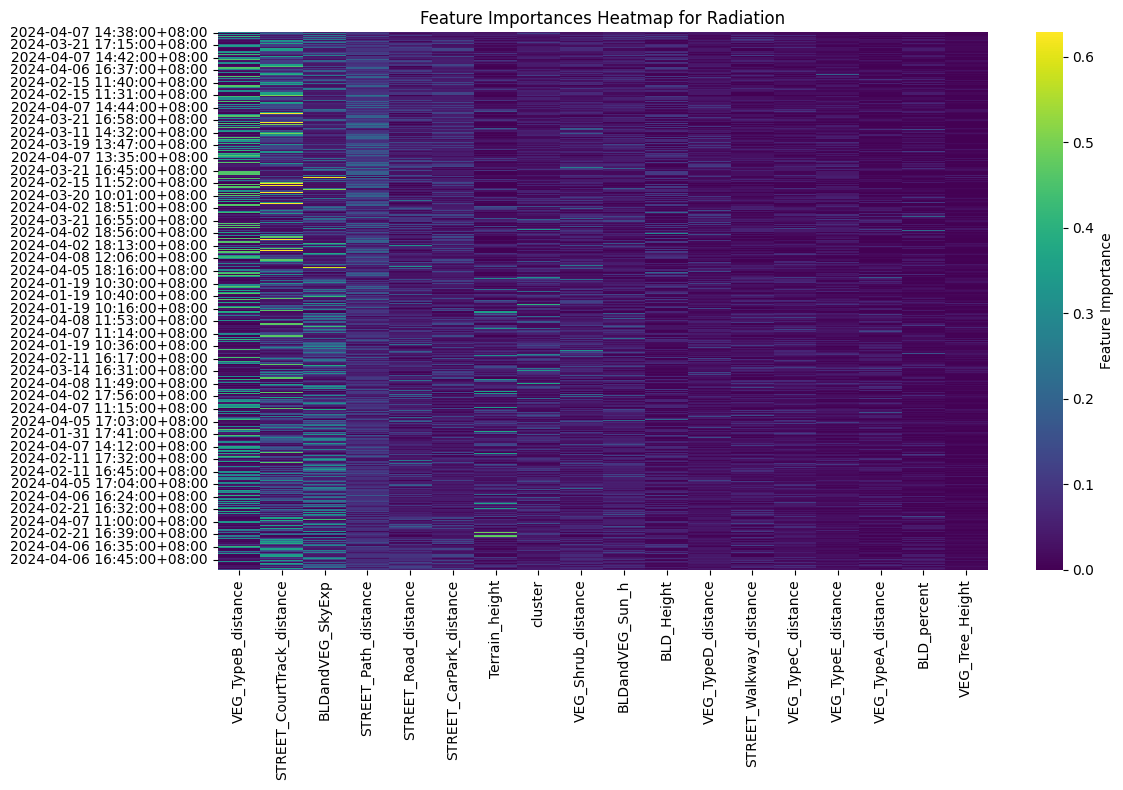

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
#measure = "AirTemperature"

# Load feature importances DataFrame (assumed to be saved as '_{measure}_FeatureImportances.csv')
feature_importance_df = pd.read_csv(f"{dirOut}/_{measure}_FeatureImportances.csv", index_col=0)

# Calculate mean importance for each feature across all timestamps
mean_importance = feature_importance_df.mean(axis=0)
sorted_features = mean_importance.sort_values(ascending=False).index

# Sort feature_importance_df by the mean importance
feature_importance_df = feature_importance_df[sorted_features]

# Add a row for the mean importances
mean_importance_df = pd.DataFrame(mean_importance[sorted_features]).T
mean_importance_df.index = ['Mean Importance']

# Combine the feature importances DataFrame with the mean importance DataFrame
combined_df = pd.concat([feature_importance_df, mean_importance_df], axis=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(combined_df, cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': 'Feature Importance'})
plt.title(f'Feature Importances Heatmap for {measure}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


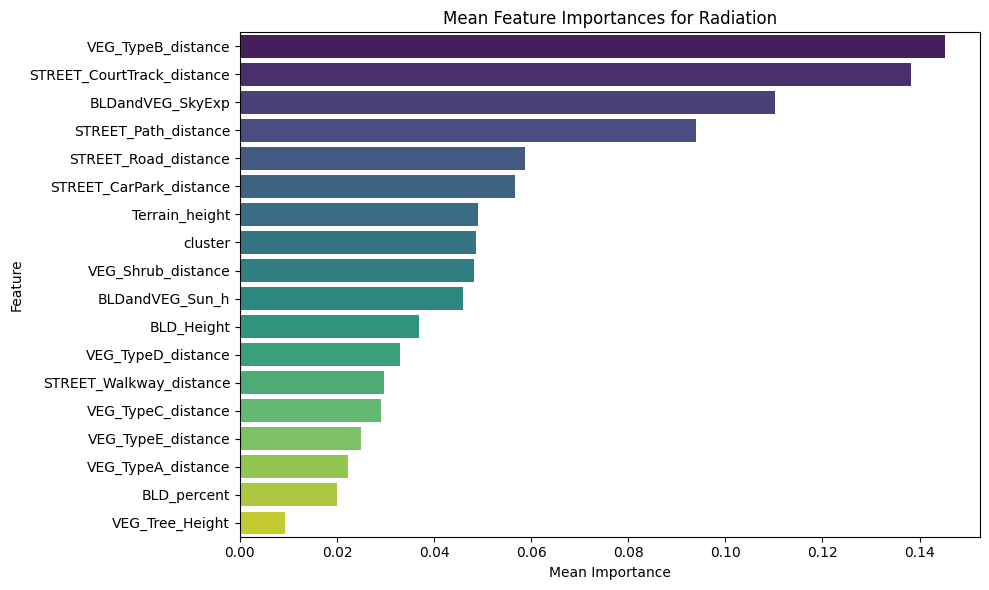

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load feature importances DataFrame
feature_importance_df = pd.read_csv(os.path.join('D:\Simulation\InterpolationResults', f"_{measure}_FeatureImportances.csv"), index_col=0)


# Calculate mean importance for each feature
mean_importance = feature_importance_df.mean(axis=0).sort_values(ascending=False)

# Create a DataFrame for the mean importances
mean_importance_df = pd.DataFrame(mean_importance).reset_index()
mean_importance_df.columns = ['Feature', 'Mean Importance']

# Plot the mean importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean Importance', y='Feature', data=mean_importance_df, palette='viridis')
plt.title(f'Mean Feature Importances for {measure}')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\833704365.py:63: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

C:\Users\gottk\AppData\Local\Temp\ipykernel_37064\833704365.py:91: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



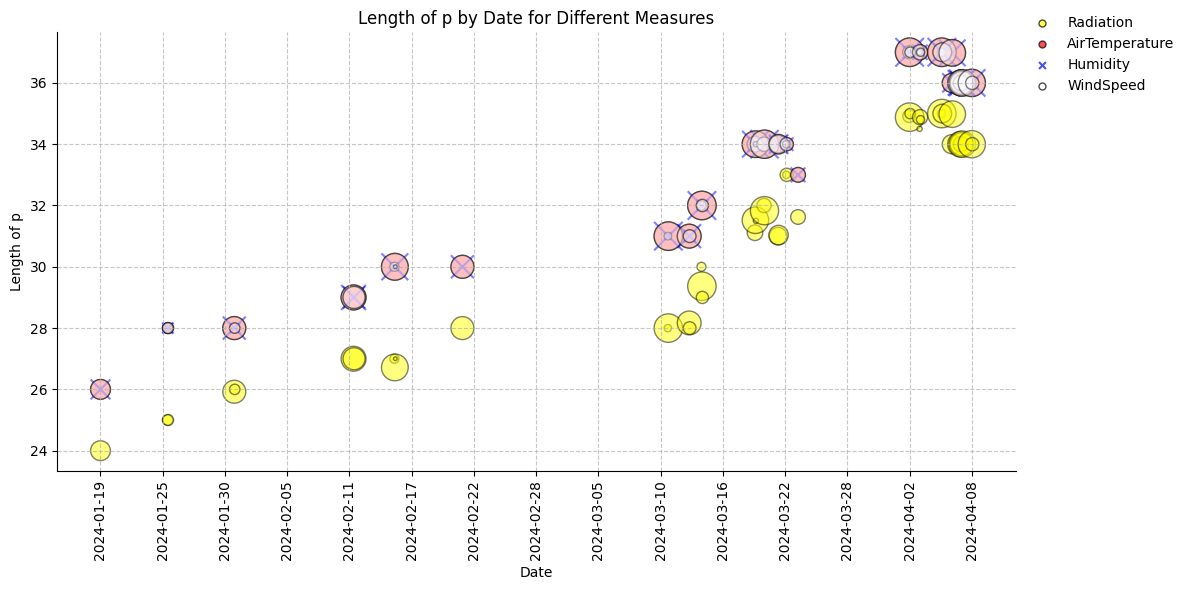

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the measures
measures = ["Radiation", "AirTemperature", "Humidity", "WindSpeed"] #"Humidity", 'WindSpeed'

# Initialize a dictionary to store daily data for each measure
daily_data_dict = {}

# for measure in measures:
#     # Load the log file into a DataFrame
#     log_df = pd.read_csv(f"{dirOut}/_{measure}_Log.csv")
    
#     # Ensure the 'hours' column is in datetime format
#     log_df['hours'] = pd.to_datetime(log_df['hours'])
    
#     # Set 'hours' as the index
#     log_df.set_index('hours', inplace=True)
    
#     # Store the data in the dictionary
#     daily_data_dict[measure] = log_df

for measure in measures:
    file_path = f"{dirOut}/_{measure}_Log.csv"
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the log file into a DataFrame
        log_df = pd.read_csv(file_path)
        
        # Ensure the 'hours' column is in datetime format
        log_df['hours'] = pd.to_datetime(log_df['hours'])
        
        # Set 'hours' as the index
        log_df.set_index('hours', inplace=True)
        
        # Store the data in the dictionary
        daily_data_dict[measure] = log_df
    else:
        print(f"File not found: {file_path}")

# Plot scatter plot for each measure
plt.figure(figsize=(12, 6))

# Define colors, markers, and edge color
colors = {'Radiation': 'yellow', "Humidity": "blue",'AirTemperature': 'red', 'WindSpeed': 'white'}
markers = {'Radiation': 'o', 'AirTemperature': 'o', 'Humidity': 'x', 'WindSpeed': 'o'}
edge_color = 'black'

# Define legend point size
legend_point_size = 25

# Plot the data points without labels for legend
for measure in measures:
    daily_data = daily_data_dict[measure]
    
    # Bin the data by hour and count number of entries in each bin
    binned_data = daily_data.resample('H').agg({'length_of_p': ['mean', 'count']})
    binned_data.columns = ['mean_length_of_p', 'count']
    
    # Scatter plot with size based on count
    plt.scatter(binned_data.index, binned_data['mean_length_of_p'], 
                color=colors[measure], 
                marker=markers[measure], 
                alpha=0.5,  # Transparency
                s=binned_data['count']*7,  # Size proportional to count
                edgecolor=edge_color)  # Black outline

# Create evenly distributed x-ticks
num_ticks = 15
if len(binned_data.index) > num_ticks:
    # Calculate indices for evenly distributed ticks
    tick_indices = np.linspace(0, len(binned_data.index) - 1, num_ticks).astype(int)
    ticks = binned_data.index[tick_indices].tolist()
else:
    ticks = binned_data.index

# Set the ticks and labels
plt.xticks(ticks=ticks, rotation=90)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Customize spines to remove top and right lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a single legend with fixed size markers
for measure in measures:
    plt.scatter([], [], color=colors[measure], marker=markers[measure], 
                alpha=0.7, s=legend_point_size, edgecolor=edge_color, label=measure)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Length of p')
plt.title('Length of p by Date for Different Measures')

# Add legend and place it to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.95), frameon=False)  # Place legend to the right and remove frame

plt.tight_layout()
plt.show()


## Add Data to the Cozie Dataframe

In [ ]:
cozieDf = pd.read_csv(
    r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', 
    parse_dates=['index_time']
)

cozieDf['index_time'] = pd.to_datetime(cozieDf['index_time'], format='mixed')
cozieDf['index_time'] = cozieDf['index_time'].dt.tz_convert('Asia/Singapore')


In [88]:
cozieDf = pd.read_csv(r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv', parse_dates=['time_slice'])

cozieDf['index_time'] = pd.to_datetime(cozieDf['time_slice'], format='mixed') 
cozieDf['index_time'] = cozieDf['index_time'].dt.tz_localize('Asia/Singapore')

def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

cozieDf['c_longitude'] = cozieDf.apply(combine_longitudes, axis=1)
cozieDf['c_latitude'] = cozieDf.apply(combine_latitudes, axis=1)

In [ ]:
import os
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from datetime import timedelta
import pytz
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

fileDirectory = r'D:\Simulation\InterpolationResults\2024-09-03_10-35'

# List of measures to process
measures = ['AirTemperature', 'Radiation', 'Humidity', 'WindSpeed']

wgs84 = Proj(init='epsg:4326')
utm = Proj(init='epsg:3414')


# Round index_time to nearest second
cozieDf['index_time'] = cozieDf['index_time'].dt.round('S')

# Copy Cozie DataFrame and prepare columns for each measure
cozieMeasureDf = cozieDf.copy()
for measure in measures:
    cozieMeasureDf[measure] = np.nan  
    cozieMeasureDf[measure + '_time_difference'] = np.nan  # Column to store time difference

def ConvertLocationDataToMeters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

def findCozieLocation():
    """
    Find valid longitude and latitude entries in Cozie DataFrame,
    convert them to meters, and return the index and transformed coordinates.
    """
    valid_entries = cozieDf.dropna(subset=['c_longitude', 'c_latitude'])
    
    for idx, row in valid_entries.iterrows():
        lon, lat = row['c_longitude'], row['c_latitude']
        x, y = ConvertLocationDataToMeters(lon, lat)
        
        yield idx, row['index_time'], x, y

def parse_filename_timestamp(filename, measure):
    """
    Parse the timestamp from the filename considering timezone offset and make it timezone-aware.
    """
    # Remove the measure prefix and file extension
    timestamp_part = filename[len(measure) + 1:-4]  # Remove measure name and '.csv', and adjust for underscore

    # Extract parts: 'YYYY-MM-DD_HH_MM_SS_TZ'
    parts = timestamp_part.split('_')
    
    # Construct timestamp string and timezone offset
    timestamp_str = '_'.join(parts[:4])  # 'YYYY-MM-DD_HH_MM_SS'
    tz_offset_str = '_'.join(parts[4:])  # '08_00'
    
    # Parse the timestamp
    try:
        file_time = pd.to_datetime(timestamp_str, format='%Y-%m-%d_%H_%M_%S')
        tz_offset_hours = int(tz_offset_str.split('_')[0])
        tz_offset_minutes = int(tz_offset_str.split('_')[1])
        tz_offset = pytz.FixedOffset(tz_offset_hours * 60 + tz_offset_minutes)
        file_time = tz_offset.localize(file_time)

        # Convert to Singapore time
        file_time = file_time.astimezone(pytz.timezone('Asia/Singapore'))

        return file_time
    except ValueError as e:
        print(f"Error parsing timestamp from filename {filename}: {e}")
        return None

def findClosestMeasureFile(index_time, measure):
    """
    Find the closest measure file based on the measure type and index_time.
    """
    min_time_diff = pd.Timedelta.max
    closest_file = None

    # Ensure index_time is timezone-aware
    if isinstance(index_time, pd.Timestamp):
        if index_time.tzinfo is None:
            index_time = index_time.tz_localize('Asia/Singapore')
    else:
        index_time = pd.Timestamp(index_time).tz_localize('Asia/Singapore')

    measure_folder = os.path.join(fileDirectory, measure)
    for root, dirs, files in os.walk(measure_folder):
        for file in files:
            if measure in file:
                file_time = parse_filename_timestamp(file, measure)
                if file_time is not None:
                    # Calculate time difference
                    time_diff = abs(file_time - index_time)
                    
                    if time_diff < min_time_diff:
                        min_time_diff = time_diff
                        closest_file = os.path.join(root, file)

    return closest_file, min_time_diff

def findGridLocation(measureFilePath, x, y, measure):
    """
    Find the closest grid cell in the measure file corresponding to the given coordinates (x, y).
    Update the CozieMeasureDf with the found value.
    """
    measureDf = pd.read_csv(measureFilePath)
    
    # Ensure the columns match the measureDf file
    if 'X' not in measureDf.columns or 'Y' not in measureDf.columns:
        raise ValueError(f"Required columns 'X' or 'Y' are missing in file {measureFilePath}")
    
    # Compute the distance
    measureDf['distance'] = np.sqrt((measureDf['X'] - x)**2 + (measureDf['Y'] - y)**2)
    
    # Find the closest row
    closest_row = measureDf.loc[measureDf['distance'].idxmin()]
    return closest_row[measure]

# Process the first 100 locations in Cozie DataFrame and update measurements for all measures
count = 0
for idx, index_time, x, y in findCozieLocation():
    # if count >= 10:
    #     break  # Stop after processing 100 locations

    for measure in measures:
        measureFilePath, time_difference = findClosestMeasureFile(index_time, measure)
        
        if measureFilePath:
            measurement_value = findGridLocation(measureFilePath, x, y, measure)
            cozieMeasureDf.loc[idx, measure] = measurement_value
            cozieMeasureDf.loc[idx, measure + '_time_difference'] = time_difference.total_seconds()
        else:
            print(f"Warning: No {measure} file found for index_time {index_time}. Data remains NaN for this entry.")
    
    count += 1  # Increment the counter
    print(f"Processed location {count}")

print("Processing complete.")


In [89]:
import os
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from datetime import timedelta
import pytz
import warnings
from concurrent.futures import ThreadPoolExecutor

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

fileDirectory = r'D:\Simulation\InterpolationResults\2024-09-09_20-00'
measures = ['AirTemperature', 'Radiation', 'Humidity', 'WindSpeed']

wgs84 = Proj(init='epsg:4326')
utm = Proj(init='epsg:3414')

cozieDf['index_time'] = cozieDf['index_time'].dt.round('S')
cozieMeasureDf = cozieDf.copy()
for measure in measures:
    cozieMeasureDf[measure] = np.nan  
    cozieMeasureDf[measure + '_time_difference'] = np.nan  

def ConvertLocationDataToMeters(lon, lat):
    return transform(wgs84, utm, lon, lat)

def findCozieLocation():
    valid_entries = cozieDf.dropna(subset=['c_longitude', 'c_latitude'])
    for idx, row in valid_entries.iterrows():
        lon, lat = row['c_longitude'], row['c_latitude']
        x, y = ConvertLocationDataToMeters(lon, lat)
        yield idx, row['index_time'], x, y

def parse_filename_timestamp(filename, measure):
    timestamp_part = filename[len(measure) + 1:-4]  
    parts = timestamp_part.split('_')
    timestamp_str = '_'.join(parts[:4])  
    tz_offset_str = '_'.join(parts[4:])  
    try:
        file_time = pd.to_datetime(timestamp_str, format='%Y-%m-%d_%H_%M_%S')
        tz_offset_hours = int(tz_offset_str.split('_')[0])
        tz_offset_minutes = int(tz_offset_str.split('_')[1])
        tz_offset = pytz.FixedOffset(tz_offset_hours * 60 + tz_offset_minutes)
        file_time = tz_offset.localize(file_time)
        file_time = file_time.astimezone(pytz.timezone('Asia/Singapore'))
        return file_time
    except ValueError as e:
        print(f"Error parsing timestamp from filename {filename}: {e}")
        return None

def build_file_index():
    file_index = {}
    for measure in measures:
        measure_folder = os.path.join(fileDirectory, measure)
        files = os.listdir(measure_folder)
        timestamps = {parse_filename_timestamp(file, measure): os.path.join(measure_folder, file)
                      for file in files}
        file_index[measure] = timestamps
    return file_index

def findClosestMeasureFile(index_time, measure, file_index):
    min_time_diff = pd.Timedelta.max
    closest_file = None

    if isinstance(index_time, pd.Timestamp) and index_time.tzinfo is None:
        index_time = index_time.tz_localize('Asia/Singapore')

    for file_time, path in file_index[measure].items():
        if file_time is not None:
            time_diff = abs(file_time - index_time)
            if time_diff < min_time_diff:
                min_time_diff = time_diff
                closest_file = path

    return closest_file, min_time_diff

def findGridLocation(measureFilePath, x, y, measure):
    measureDf = pd.read_csv(measureFilePath)
    if 'X' not in measureDf.columns or 'Y' not in measureDf.columns:
        raise ValueError(f"Required columns 'X' or 'Y' are missing in file {measureFilePath}")
    
    measureDf['distance'] = np.sqrt((measureDf['X'] - x)**2 + (measureDf['Y'] - y)**2)
    closest_row = measureDf.loc[measureDf['distance'].idxmin()]
    return closest_row[measure]

def process_location(location_data, file_index):
    idx, index_time, x, y = location_data
    for measure in measures:
        measureFilePath, time_difference = findClosestMeasureFile(index_time, measure, file_index)
        if measureFilePath:
            measurement_value = findGridLocation(measureFilePath, x, y, measure)
            cozieMeasureDf.loc[idx, measure] = measurement_value
            cozieMeasureDf.loc[idx, measure + '_time_difference'] = time_difference.total_seconds()
            print(f"processed location for {index_time}")
        else:
            print(f"Warning: No {measure} file found for index_time {index_time}. Data remains NaN for this entry.")

file_index = build_file_index()

with ThreadPoolExecutor() as executor:
    list(executor.map(lambda location: process_location(location, file_index), findCozieLocation()))

print("Processing complete.")


processed location for 2024-01-19 10:27:15+08:00processed location for 2024-01-19 10:13:53+08:00

processed location for 2024-01-19 10:27:18+08:00
processed location for 2024-01-19 10:27:16+08:00
processed location for 2024-01-19 10:27:19+08:00
processed location for 2024-01-19 10:25:35+08:00
processed location for 2024-01-19 10:30:56+08:00
processed location for 2024-01-19 10:19:41+08:00
processed location for 2024-01-19 10:27:13+08:00
processed location for 2024-01-19 10:29:12+08:00
processed location for 2024-01-19 10:30:57+08:00
processed location for 2024-01-19 10:30:53+08:00
processed location for 2024-01-19 10:27:14+08:00
processed location for 2024-01-19 10:30:49+08:00
processed location for 2024-01-19 10:31:08+08:00
processed location for 2024-01-19 10:31:14+08:00
processed location for 2024-01-19 10:30:59+08:00
processed location for 2024-01-19 10:31:16+08:00
processed location for 2024-01-19 10:31:20+08:00
processed location for 2024-01-19 10:31:19+08:00
processed location f

In [90]:
cozieMeasureDf.to_csv('cozieMeasureDf.csv')
